In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = get_training_data('/content/drive/MyDrive/CS231_CV/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/CS231_CV/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/CS231_CV/chest_xray/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



#Data Visualization & Preprocessing

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


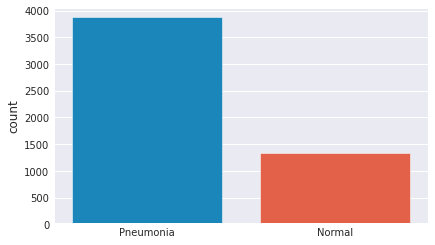

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


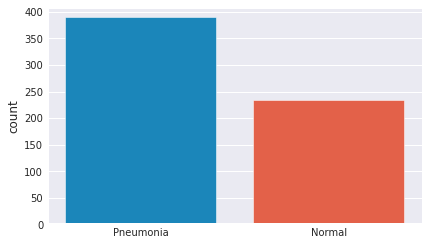

In [ ]:
l = []
for i in test:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


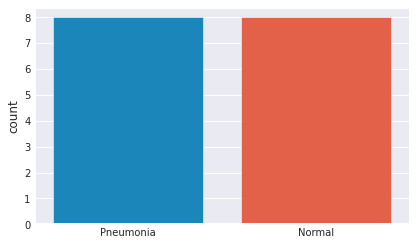

In [ ]:
l = []
for i in val:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

Text(0.5, 1.0, 'NORMAL')

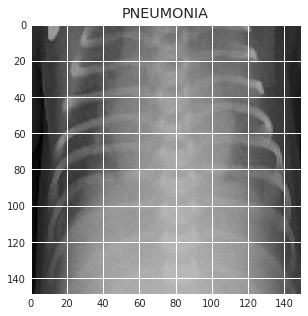

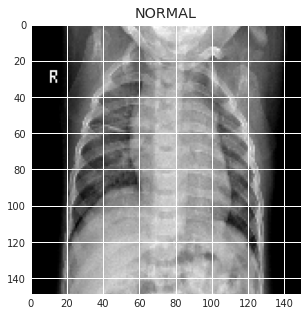

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


X = np.array(X).reshape(-1, img_size, img_size, 3)
y = np.array(y)

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

#Data Augmentation

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True) 
datagen.fit(X_train)

#Training the Model

In [ ]:
from keras.applications.vgg16 import VGG16
from keras import layers

In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation="sigmoid"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['acc']
    )
    return model

vgg16=tf.keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

model = build_model(vgg16 ,lr = 1e-4)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 4096)              33558528  
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
for layer in vgg16.layers[:22]:
    layer.trainable = False

In [ ]:
for i, layer in enumerate(vgg16.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_pool - False
11 block4_conv1 - False
12 block4_conv2 - False
13 block4_conv3 - False
14 block4_pool - False
15 block5_conv1 - False
16 block5_conv2 - False
17 block5_conv3 - False
18 block5_pool - False


#Callbacks

In [ ]:

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
callbacks =[
    ModelCheckpoint("vgg16_1.h5", monitor = 'val_acc', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'auto'
        ),
   # EarlyStopping(patience=4, monitor='val_acc', verbose=1),
    ReduceLROnPlateau(
      monitor='val_acc',
      patience=2,
      verbose=1,
      factor=0.3,
      min_lr=0.000001
)
]
# checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

#Model Training

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, shuffle=True),
    epochs=30,
    validation_data=datagen.flow(X_val, y_val),
    callbacks=[callbacks]
)

Epoch 1/30
138/138 [==============================] - ETA: 0s - loss: 0.6782 - acc: 0.7247
Epoch 1: val_acc improved from -inf to 0.76879, saving model to vgg16_1.h5
138/138 [==============================] - 114s 706ms/step - loss: 0.6782 - acc: 0.7247 - val_loss: 0.3914 - val_acc: 0.7688 - lr: 1.0000e-04
Epoch 2/30
138/138 [==============================] - ETA: 0s - loss: 0.3728 - acc: 0.8192
Epoch 2: val_acc improved from 0.76879 to 0.88497, saving model to vgg16_1.h5
138/138 [==============================] - 92s 666ms/step - loss: 0.3728 - acc: 0.8192 - val_loss: 0.3129 - val_acc: 0.8850 - lr: 1.0000e-04
Epoch 3/30
138/138 [==============================] - ETA: 0s - loss: 0.2902 - acc: 0.8809
Epoch 3: val_acc improved from 0.88497 to 0.89863, saving model to vgg16_1.h5
138/138 [==============================] - 92s 667ms/step - loss: 0.2902 - acc: 0.8809 - val_loss: 0.2493 - val_acc: 0.8986 - lr: 1.0000e-04
Epoch 4/30
138/138 [==============================] - ETA: 0s - loss: 0.

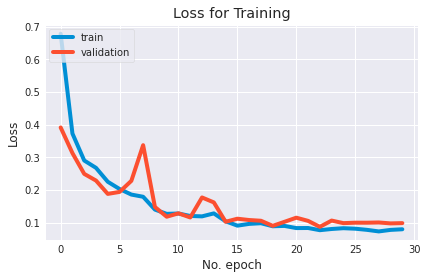

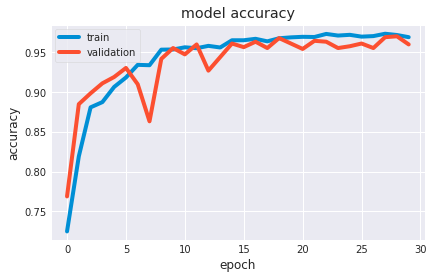

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Loss for Training')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(['train', 'validation'], loc="upper left")
plt.show()

plt.plot(history.epoch, history.history['acc'])
plt.plot(history.epoch, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
predictions = model.predict(X_test) 
classes_x=np.argmax(predictions,axis=1)

predictions = predictions.reshape(1,-1)[0]
predictions[:15]
print(classification_report(y_test, predictions.round(), target_names=labels))

              precision    recall  f1-score   support

   PNEUMONIA       0.99      0.95      0.97       434
      NORMAL       0.88      0.96      0.92       152

    accuracy                           0.96       586
   macro avg       0.93      0.96      0.94       586
weighted avg       0.96      0.96      0.96       586



In [ ]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

In [ ]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

#Confunsion Matrix

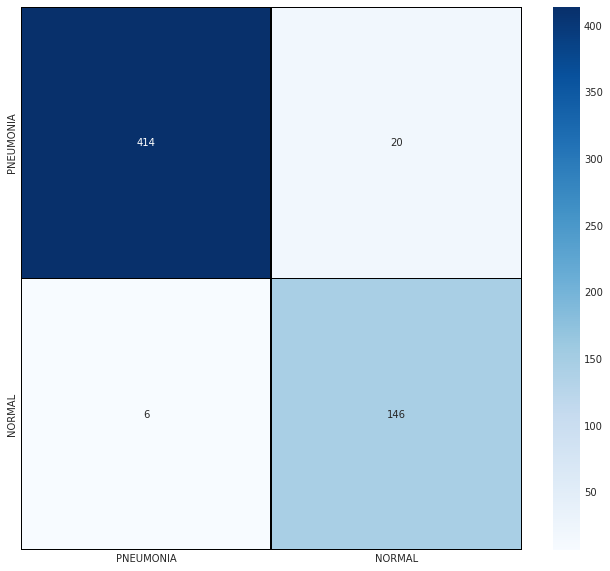

In [ ]:
cm = confusion_matrix(y_test, predictions.round())

plt.figure(figsize=(10,10))
sns.heatmap(cm, cmap="Blues", linecolor='black',
            linewidth=1, annot=True, fmt='', xticklabels=labels,
            yticklabels=labels)
plt.show()

#Xem kết quả dự đoán của 36 bức ảnh so với tập test

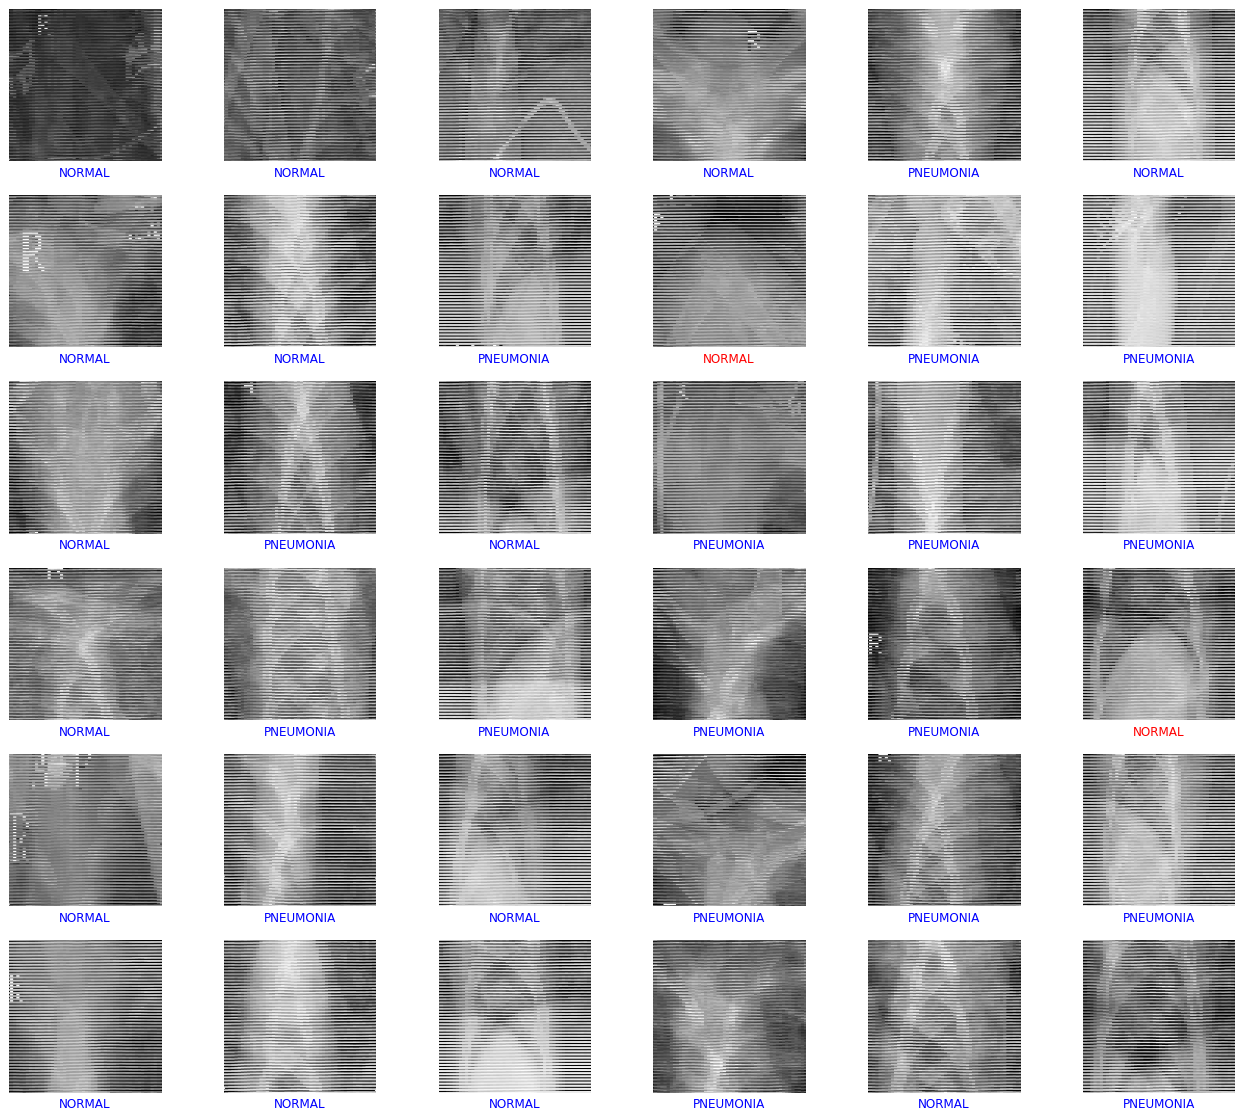

In [ ]:
plt.figure(figsize=(20,20))    #Thay đổi kích thước của hình vẽ (20,20)
for i in range(36):            #For loop with range (36)
    plt.subplot(6,6,i+1)       #The figure has 6 row, 6 columns, and this plot is the(i+1) plot
    plt.xticks([])             #The matplotlib.pyplot.xticks() function is used to get or set the current tick locations and labels of the x-axis. It passes no arguments to return the current values without modifying them.      
    plt.yticks([])
    plt.grid(False)            #Định cấu hình các đường lưới
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()